# 1D Toy Example - Quadratic SDE

The purpose of this notebook is to provide a simple implementation of our proposed SMDP method, which combines physics and score matching to solve inverse problems. </br> We consider the simple toy problem, which is shown in Figure 1 in the main paper and discussed in more detail in Appendix B. </br>

Our implementation comprises the data generation, network definition, training using the sliding window method, </br> 
visualization of the learned score and inference using the probability flow ODE and the reverse-time SDE. </br>
The core algorithm for training and inference can be modified easily for different variants that are discussed in the paper. 

### Required packages
Our training implementation uses **JAX** with **haiku** and **optax** as neural network libraries. For data generation and inference, we use **diffrax**==0.1.2

In [1]:
import warnings
warnings.filterwarnings('ignore')

from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, WeaklyDiagonalControlTerm
import diffrax as dfx

import jax
import jax.random as jr
import jax.numpy as jnp
import optax
import haiku as hk

We use **os**, **random**, **math**, **functools**, **numpy**, **scipy**, **tqdm** and **typing** as helper libraries 

In [2]:
import math
import numpy as np
from tqdm import tqdm
from scipy.interpolate import griddata
from typing import Any, Callable, Iterable, List, Optional, Tuple, Union

For visualizations, we use **matplotlib==3.5.1** and **seaborn** 

In [3]:
from matplotlib import pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

import seaborn as sns

## Physical System SDE

As physical system, we consider the SDE defined by 

$dx = - \lambda$ sign$(x) x^2 dt + g dW$

with $\lambda = 7$ and $g = 0.03$.

Paths of this SDE will start in either $-1$ or $1$ at $t=0$ and approach $0$ as $t$ increases.

In [4]:
g = 0.03
lambda_ = 7
physics_operator = lambda x: - jnp.sign(x) * x * x * lambda_

We use diffrax to solve the SDE with Euler steps

In [5]:
def r_process(initial_value, noise_scaling, seed):

    initial_shape = (1,)
    y0 = jnp.ones(shape=initial_shape) * initial_value

    t0, t1 = 0.0, 10.0
    drift = lambda t, y, args: physics_operator(y)

    diffusion = lambda t, y, args: noise_scaling * jnp.ones(initial_shape)

    brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=initial_shape, key=jr.PRNGKey(seed))
    terms = MultiTerm(ODETerm(drift), WeaklyDiagonalControlTerm(diffusion, brownian_motion))
    solver = Euler()
    saveat = SaveAt(dense=True)

    sol = diffeqsolve(terms, solver, t0, t1, dt0=0.01, y0=y0, saveat=saveat)
    
    return sol

## Visualization of SDE paths
We first set a *seed* for the SDE paths

In [3]:
seed = 2022

Next, we define some options for plotting

In [7]:
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":5})
sns.set(font_scale=1.5, rc={'text.usetex' : True})
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'white', 'axes.labelcolor' : "black", 'text.color' : "black"})

Now, we plot paths from for the SDE 

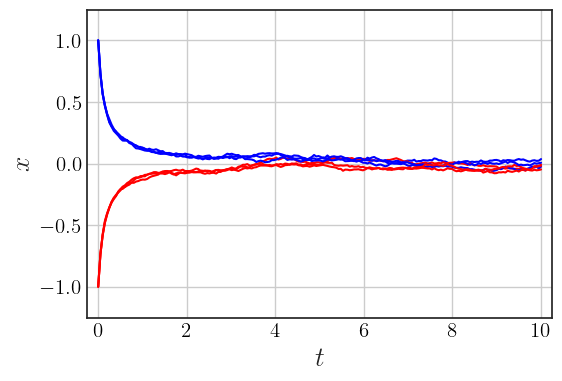

In [8]:
with plt.style.context("seaborn-white"):

    # paths starting in 1.0
    value_one = [r_process(1.0, g, seed+n) for n in range(0, 3)]
    
    # paths starting in -1.0
    value_minus_one = [r_process(-1.0, g, seed+n) for n in range(3, 6)]

    fig, ax = plt.subplots(figsize=(6,4))

    x = jnp.linspace(0,10,200)
    
    for i in range(3):
    
        sol = value_one[i]
        ax.plot(x, jnp.diag(sol.evaluate(x)), color='blue')

        sol = value_minus_one[i]
        ax.plot(x, jnp.diag(sol.evaluate(x)), color='red')

    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    ax.set_xlabel(r'$t$', size = 20)
    ax.set_ylabel(r'$x$', size = 20)
    ax.grid(True)
    ax.tick_params(labelsize=15)

    plt.xlim([-0.25, 10.25])
    plt.ylim([-1.25,1.25])

    plt.show()

## Generate Training Data

We generate a data set of 250 paths from $t=0$ until $t=10$ with $\Delta t = 0.02$

In [9]:
import os.path
import pickle

if os.path.isfile('toy_example_data.p'):

    with open('toy_example_data.p', 'rb') as file:

        dataset = pickle.load(file)
        
else:
    
    dataset = []
    x = jnp.linspace(0,10,500)

    for n in tqdm(range(250)):
        sol = r_process((-1) ** n, g, seed+n)
        dataset.append(jnp.diag(sol.evaluate(x)))

data = jnp.array(dataset)


In [10]:
import pickle
with open('toy_example_data.p', 'wb') as file:
    pickle.dump(dataset, file)

Next, we implement iterator functions for the dataset

In [11]:
def _prepare_batch(batch):
    
    batch_x = batch[:,::-1]
    batch_t = jnp.linspace(0,10, batch_x.shape[1])[::-1]

    return (batch_x, batch_t)

def iterbatches(X, batch_size, shuffle=False):

    
    def iterate(X, batch_size, shuffle=False):
        n_samples = X.shape[0]
        
        ids = np.arange(n_samples)
        sample_perm = np.arange(n_samples)
        if batch_size is None:
            batch_size = n_samples
        if shuffle:
            sample_perm = np.random.permutation(n_samples)
        batch_idx = 0
        num_batches = math.ceil(n_samples / batch_size)
        while batch_idx < num_batches:
            start = batch_idx * batch_size
            end = min(n_samples, (batch_idx + 1) * batch_size)
            indices = range(start, end)
          
            perm_indices = sample_perm[indices]
            X_batch = X[perm_indices]
            ids_batch = ids[perm_indices]
          
            batch_idx += 1
            yield X_batch

    return iterate(X, batch_size, shuffle)

Additionally, we implement iterator functions required for the score field visualization

In [12]:
def _prepare_batch_grid(batch):
    
    inputs = [np.split(x, x.shape[1], 1) for x in batch]

    return inputs

def iterbatches_grid(X, batch_size, shuffle=False):

    def iterate(X, batch_size, shuffle=False):
        n_samples = X.shape[0]
        
        sample_perm = np.arange(n_samples)
        if batch_size is None:
            batch_size = n_samples
        if shuffle:
            sample_perm = np.random.permutation(n_samples)
        batch_idx = 0
        num_batches = math.ceil(n_samples / batch_size)
        while batch_idx < num_batches:
            start = batch_idx * batch_size
            end = min(n_samples, (batch_idx + 1) * batch_size)
            indices = range(start, end)
          
            perm_indices = sample_perm[indices]
            X_batch = X[perm_indices]
          
            batch_idx += 1
            yield ([X_batch])

    return iterate(X, batch_size, shuffle)

## Neural Network Setup

First, we define the neural network architecture using haiku

In [13]:
EPSILON = 1e-5

def f(x, t):
    t = jnp.log(t + EPSILON)
    x = jnp.hstack([x, t])
    net = hk.nets.MLP(output_sizes = [30, 30, 25, 20, 10, 1],
                    activation = jax.nn.elu)
    return net(x)

Then, we initialize the parameters

In [14]:
init_params, forward_fn = hk.transform(f)
rng = jax.random.PRNGKey(0)

x_init = jnp.ones((10,1))
t_init = x_init
params = init_params(rng, x_init, t_init)

We define a function to evaluate the model and a function that implements the backpropagation and updating of parameters given the optimizer and model loss

In [15]:
def create_eval_fn(forward_fn, params):
    """
    Evaluate model
    """
    @jax.jit
    def eval_model(t, x, rng=None):
       
        res = forward_fn(params, rng, x, t)
        return res
    return eval_model

def create_default_update_fn(optimizer: optax.GradientTransformation,
                             model_loss: Callable):
    """
    Update parameters and backpropagation
    """

    @jax.jit
    def update(params, opt_state, batch, rng) -> Tuple[hk.Params, optax.OptState, jnp.ndarray]:
       
        batch_loss, grads = jax.value_and_grad(model_loss)(params, rng, *batch)
        updates, opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, opt_state, batch_loss
    return update

Finally, we implement the ODE solver for the probability flow ODE using Euler steps, </br> 
which given an initial state and ground truth (**x_train**) as well as time discretization (**t_train**) compute the L2 loss 

In [16]:
def gradient_fn(forward_fn, physics_operator, g):

    @jax.jit
    def model_loss(model_weights, rng, x_train, t_train):
        
        x = x_train[:,0]
        i = 1
        
        loss = 0.0
      
        for t1, t0 in zip(t_train, t_train[1:]):
            
            delta_t = t1-t0
        
            physics_update = physics_operator(x)
            
            # note that we absorb g**2 (constant) in the definition of forward_fn here
            score_update = - 0.5 * forward_fn(model_weights, rng, jnp.expand_dims(x, axis=1), 
                                              jnp.repeat(jnp.tile(t1, 1)[None], x.shape[0], axis=0))[:,0]
         
            x = x - delta_t * (physics_update + score_update)
     
            x_true = x_train[:,i]
      
            loss += jnp.mean(jnp.square(x - x_true))
            i += 1
        
        return loss

    return model_loss

## Visualization of Score Field

We implement the visualization of the score field, which we will be using during and after training. </br>
First, we set up the grids used for plotting.

In [17]:
x_ = np.linspace(0., 10., 400)
y_ = np.linspace(-1.25, 1.25, 200)

X, Y = np.meshgrid(x_,y_)
full_domain = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
meshgrid = (X,Y)

This function plots the score field 

In [18]:
dpi = 200
height = 6
width = 4 
scaling_factor = 1.

def save_snapshot_score(params, forward_fn, meshgrid, step=None, savename=None):
    eval_fn = create_eval_fn(forward_fn, params)
    
    results = None
    
    X, Y = meshgrid
    full_domain = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
    
    full_domain_scaled = full_domain * scaling_factor
    
    generator = iterbatches_grid(full_domain_scaled, 1000, shuffle=False)
    for batch in generator:
        inputs = _prepare_batch_grid(batch)
        
        output_values = eval_fn(*inputs[0], rng)
        if isinstance(output_values, jnp.ndarray):
            output_values = [output_values]
        output_values = [jax.device_get(t) for t in output_values]

        if results is None:
            results = [[] for i in range(len(output_values))]
        for i, t in enumerate(output_values):
            results[i].append(t)

    final_results = []
    if results is not None:
        for r in results:
            final_results.append(np.concatenate(r, axis=0))
    
    x_scaled = x_ * scaling_factor
    y_scaled = y_ * scaling_factor
    meshgrid_scaled = (meshgrid[0] * scaling_factor, meshgrid[1] * scaling_factor)
    
    fig, axes = plt.subplots(nrows = 1, ncols=1, figsize=(height,width))
    fig.set_dpi(dpi)
    
    ax = axes  

    u_pred = final_results[0][:].flatten()
    U_pred = griddata(full_domain_scaled, u_pred.flatten(), meshgrid_scaled, method='cubic')
   
    vmax = 75 
    h = ax.imshow(jnp.flip(U_pred / (g**2), axis=0), cmap='jet', 
                  extent=[ x_scaled.min(), x_scaled.max(), y_scaled.min(), y_scaled.max()], 
                  aspect='auto', vmin = -vmax, vmax = vmax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.10)
    cbar = fig.colorbar(h, cax=cax)
    cbar.ax.tick_params(labelsize=15) 
    ax.set_xlabel(r"$t$", color="black", size=20)
    ax.set_ylabel(r"$x$", color="black", size=20)
 
    ax.tick_params(labelsize=15)
    
    axTransform = {'horizontalalignment':'right',
             'verticalalignment':'center', 'transform':ax.transAxes}
    
    ax.grid(False)
    
    ax.patch.set_edgecolor('black') 
    ax.patch.set_linewidth('1')  
    
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    
    if savename:
        plt.savefig(f'{savename}.svg', transparent=True)

    plt.show()

## Training and Sliding Window Method

We implement the sliding window method and training algorithm below. </br>
The sliding window method starts with window size **ROLLOUT_start**, which is increased by **ROLLOUT_add** every **steps** epochs for **ROLLOUT_increases** times. </br>
To reduce the number of points on a trajectory, we use subsampling (defined by **subsample**)

In [19]:
def update_network(params_, forward_fn, dataset, rng, steps = 20, ROLLOUT_increases = 18, max_training_time=None, 
                   ROLLOUT_start = 4, ROLLOUT_add = 2, lr=5e-4, bidirectional=False, subsample=5):
    
    # Learning rate 
    scheduler = optax.piecewise_constant_schedule(
        init_value=lr)
    
    # Optax otimizer using Adam
    opt = optax.chain(
        optax.scale_by_adam(b1=0.9, b2=0.99),
        optax.scale_by_schedule(scheduler),
        optax.scale(-1.0))
    opt_state = opt.init(params_)
    
    # Define model loss and update for network parameters
    model_loss_fn = gradient_fn(forward_fn, physics_operator, g)
    grad_update = create_default_update_fn(opt, model_loss_fn)
    
    avg_loss = 0
    grad_updates = 0
    
    ROLLOUT = ROLLOUT_start
    history = []
    
    # Iterate through all sliding window sizes
    for _ in range(ROLLOUT_increases+1):
        
        print('Window size: ', ROLLOUT)
        
        pbar = tqdm(range(steps))
        
        # Iterate through all epochs
        for n in pbar:

            # Iterate through data set
            generator = iterbatches(dataset, 256, shuffle=False)
            for batch in generator:
                x_train, t_train = _prepare_batch(batch)
                
                
                # Concentrate on specific parts of trajectory
                if max_training_time is not None:
                    
                    x_train = x_train[:, -max_training_time:]
                    t_train = t_train[-max_training_time:]
                
                
                # Use subsampling to reduce number of points on trajectory
                x_train = x_train[:, ::subsample]
                t_train = t_train[::subsample]
                
                
                # Iterate through trajectory
                
                for t in range(x_train.shape[1]):
                    
                    # Select values based on position and window size
                    x_train_sub = x_train[:, t:t+ROLLOUT]
                    t_train_sub = t_train[t:t+ROLLOUT]
                   

                    # Compute loss for current part of trajectory
                    params_, opt_state, batch_loss_backward = grad_update(params_, opt_state, [x_train_sub, t_train_sub], rng=rng)
                    
                    # Reverse values and time discretization for the forward time direction
                    if bidirectional:
                        params_, opt_state, batch_loss_forward = grad_update(params_, opt_state, 
                                                                             [x_train_sub[:,::-1], t_train_sub[::-1]], rng=rng)
                    
                    grad_updates += 1

                    rng, _ = jax.random.split(rng)
                    avg_loss += jax.device_get(batch_loss_backward)
                    if bidirectional:
                        avg_loss += jax.device_get(batch_loss_forward)
                        
                    history.append(batch_loss_backward+batch_loss_forward)

            pbar.set_description(f'loss: {avg_loss/(n+1):.5f} grad updates: {grad_updates}')
            
        # Plot score field for each window size
        with plt.style.context("seaborn-white"):
            save_snapshot_score(params_, forward_fn, meshgrid, savename=f'score_field_{ROLLOUT}')
            
        ROLLOUT += ROLLOUT_add 
    
    return params_, history

We plot the score field before any training is done

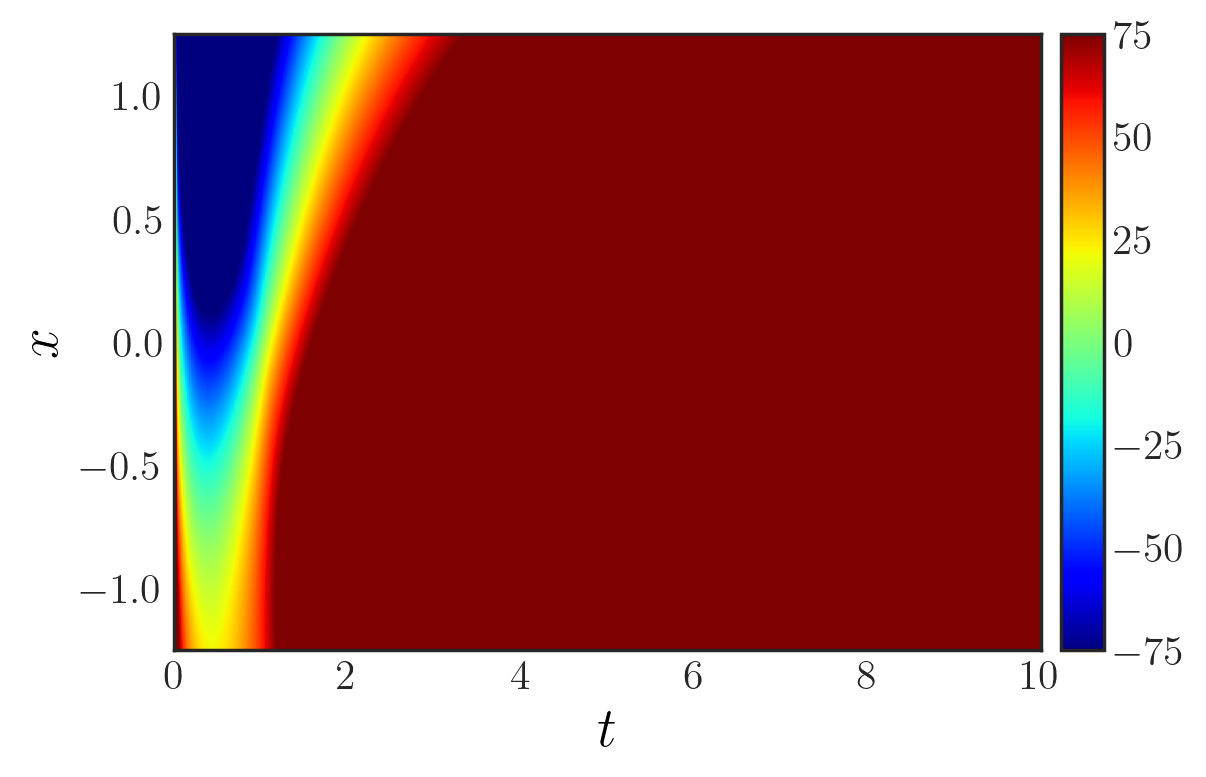

In [20]:
with plt.style.context("seaborn-white"):
    save_snapshot_score(params, forward_fn, meshgrid)

### Single step loss - Sliding window size 2
We train the score network with the single step loss for 2500 epochs using the probability flow ODE (see Single steps, Section 3) </br>
First, we use subsampling with factor 5 to reduce the number of points on the trajectory

Window size:  2


loss: 0.02312 grad updates: 250000: 100%|███| 2500/2500 [09:21<00:00,  4.45it/s]


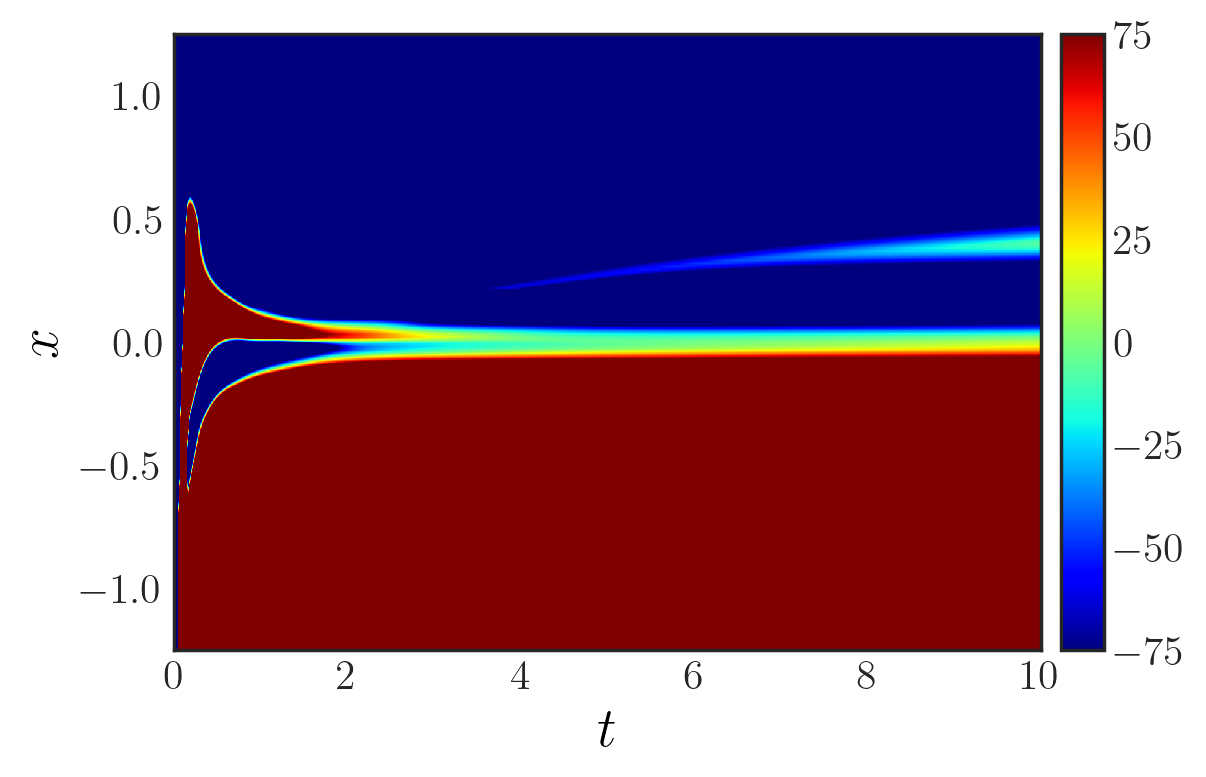

In [21]:
key = jax.random.PRNGKey(seed)
params_single_step, history = update_network(params, forward_fn, data, key, steps = 2500, 
                                             ROLLOUT_start=2, ROLLOUT_increases=0, bidirectional=True, lr=1e-3,
                                             subsample=5)

Plot the training loss 

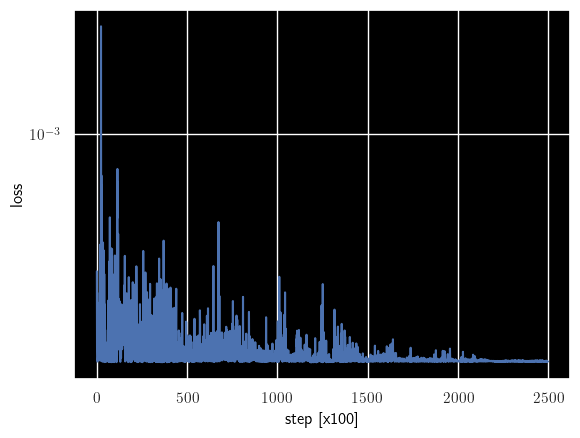

In [22]:
plt.plot(np.array(history[::100]))
plt.yscale('log')
plt.xlabel('step [x100]')
plt.ylabel('loss')
plt.show()

We decrease the learning rate and train without subsampling of the trajectories

Window size:  2


loss: 0.01601 grad updates: 500000: 100%|███| 1000/1000 [18:24<00:00,  1.10s/it]


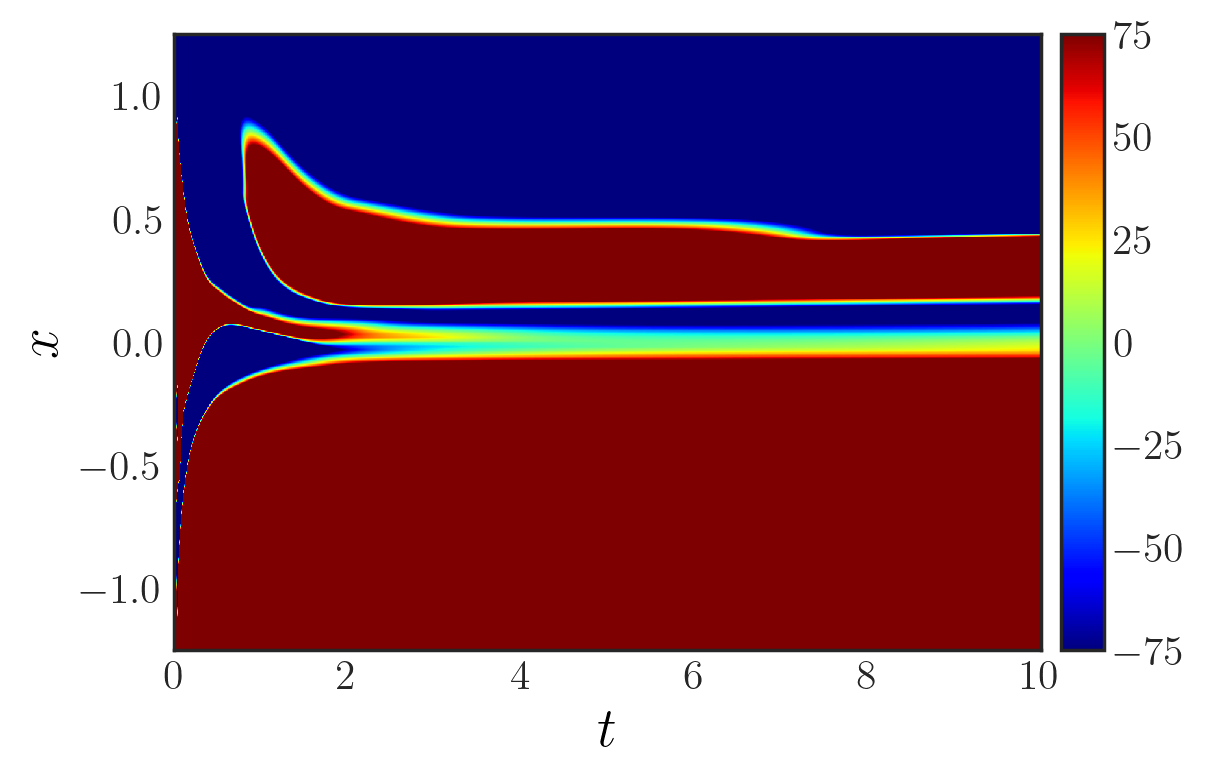

In [23]:
params_single_step, history = update_network(params_single_step, forward_fn, data, key, steps = 1000, 
                                             ROLLOUT_start=2, ROLLOUT_increases=0, bidirectional=True, lr=1e-4, 
                                             subsample=1)

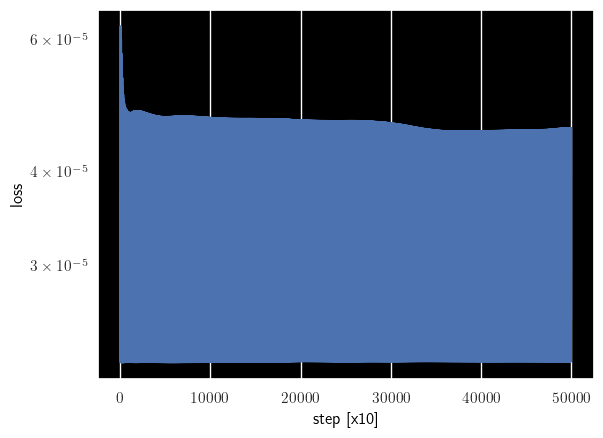

In [30]:
plt.plot(np.array(history[::10]))
plt.yscale('log')
plt.xlabel('step [x10]')
plt.ylabel('loss')
plt.show()

## Single-step Inference
We use the trained score with diffrax to solve the probability flow ODE and simulate paths from the reverse-time SDE. </br>
For this task, it is sufficient to train with the single step objective only and not consider higher sliding window sizes.

### Reverse-time SDE
We define a function to simulate paths from the reverse-time SDE with diffrax

In [25]:
def r_process_reverse(initial_value, params, noise_scaling, seed):
    key = jr.PRNGKey(seed)
    initial_shape = (1,)
    y1 = jnp.ones(shape=initial_shape) * initial_value

    t0, t1 = 0.0, 10.0
    dt0 = 0.01
    
    def drift(t, y, args):
        return physics_operator(y) - forward_fn(params, key, y, t)
        
    diffusion = lambda t, y, args: noise_scaling * jnp.ones(initial_shape)

    brownian_motion = VirtualBrownianTree(t1, t0, tol=1e-3, shape=initial_shape, key=key)
    terms = MultiTerm(ODETerm(drift), WeaklyDiagonalControlTerm(diffusion, brownian_motion))
 
    solver = dfx.Euler()
 
    t0 = jnp.array(0.0)
    
    args = None
    tprev = jnp.array(t1)
    tnext = jnp.array(t1 - dt0)
    y = y1
    
    state = solver.init(terms, tprev, tnext, y1, args)
    
    y_list = []
    
    for i in range(((t1-t0) / dt0).astype(int)):
       
        y, _, _, state, _ = solver.step(terms, tprev, tnext, y, args, state, made_jump=False)
        
        tprev = tnext
    
        tnext = jnp.array(jnp.maximum(tprev - dt0, t0))
    
        y_list.append(y)
    
    return y_list

Next, we plot ten different paths from the reverse-time SDE

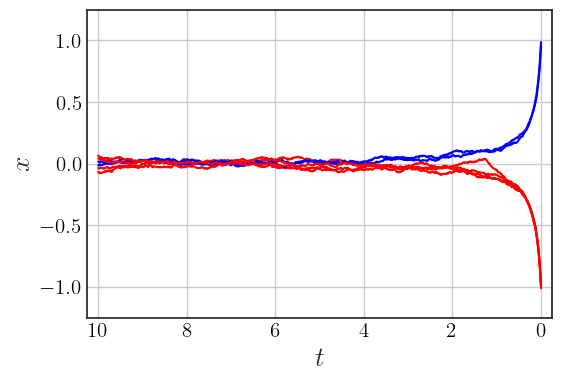

In [26]:
with plt.style.context("seaborn-white"):
    combinations = zip(np.linspace(-0.065,0.065, 6), range(6))

    fig, ax = plt.subplots(figsize=(6,4))

    for init, seed_ in combinations:
        sol = r_process_reverse(init, params_single_step, g, seed_)
        if sol[-1] > 0:
            col = 'blue'
        else:
            col = 'red'
        ax.plot(np.linspace(10.0, 0.0, 1000), sol, color=col)

    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    ax.set_xlabel(r'$t$', size = 20)
    ax.set_ylabel(r'$x$', size = 20)
    ax.grid(True)
    ax.tick_params(labelsize=15)
    
    plt.xlim([10.25, -0.25])
    plt.ylim([-1.25,1.25])

    plt.show()

### Probability flow ODE

Analogously, we define a function to solve the probability flow ODE

In [27]:
def r_process_reverse_ode(initial_value, params, noise_scaling, seed):
    key = jr.PRNGKey(seed)
    initial_shape = (1,)
    y1 = jnp.ones(shape=initial_shape) * initial_value

    t0, t1 = 0.0, 10.0
    dt0 = 0.01

    def drift(t, y, args):
        return physics_operator(y) - 0.5 * forward_fn(params, key, y, t)
        
    terms = ODETerm(drift)
    solver = dfx.Euler()
  
    t0 = jnp.array(0.0)
    
    args = None
    tprev = jnp.array(t1)
    tnext = jnp.array(t1 - dt0)
    y = y1
    
    state = solver.init(terms, tprev, tnext, y1, args)
    
    y_list = []
    
    for i in range(((t1-t0) / dt0).astype(int)):
   
        y, _, _, state, _ = solver.step(terms, tprev, tnext, y, args, state, made_jump=False)
        
        tprev = tnext
     
        tnext = jnp.array(jnp.maximum(tprev - dt0, t0))
    
        y_list.append(y)
    
    return y_list

Finally, we plot the solutions to the probability flow ODE

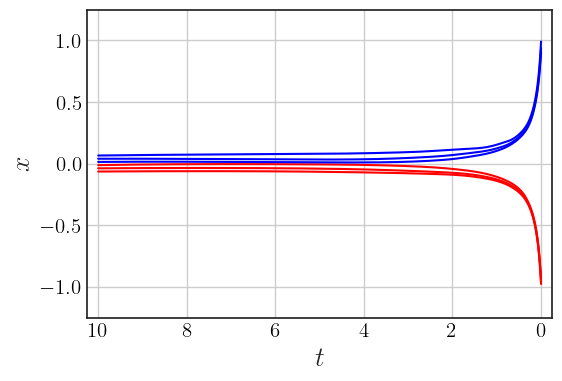

In [28]:
with plt.style.context("seaborn-white"):
    combinations = zip(np.linspace(-0.065,0.065, 6), range(6))

    fig, ax = plt.subplots(figsize=(6,4))

    for init, seed_ in combinations:
        sol = r_process_reverse_ode(init, params_single_step, g, seed_)
        if sol[-1] > 0:
            col = 'blue'
        else:
            col = 'red'
        ax.plot(np.linspace(10.0, 0.0, 1000), sol, color=col)


    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    ax.set_xlabel(r'$t$', size = 20)
    ax.set_ylabel(r'$x$', size = 20)
    ax.grid(True)
    ax.tick_params(labelsize=15)

    plt.xlim([10.25, -0.25])
    plt.ylim([-1.25,1.25])
    plt.show()